# RNN vs LSTM on Bitcoin dataset

## What is the differences between RNN & LSTM?

Before I tell you what is LSTM let me tell you about the biggest problem with RNNs. So far everything looks good about RNNs until we train it via back-propagation. As the gradient of our training samples gets propagated backward through our network, it gets weaker and weaker, by the time it gets to those neurons that represent older data points in our time-series it has no juice to adjust them properly. This problem is called Vanishing Gradient. A LSTM cell is a type of RNN which stores important information about the past and forgets the unimportant pieces. In this way, when gradient back-propagates, it won’t be consumed by unnecessary information.

In [1]:
from IPython.display import Image

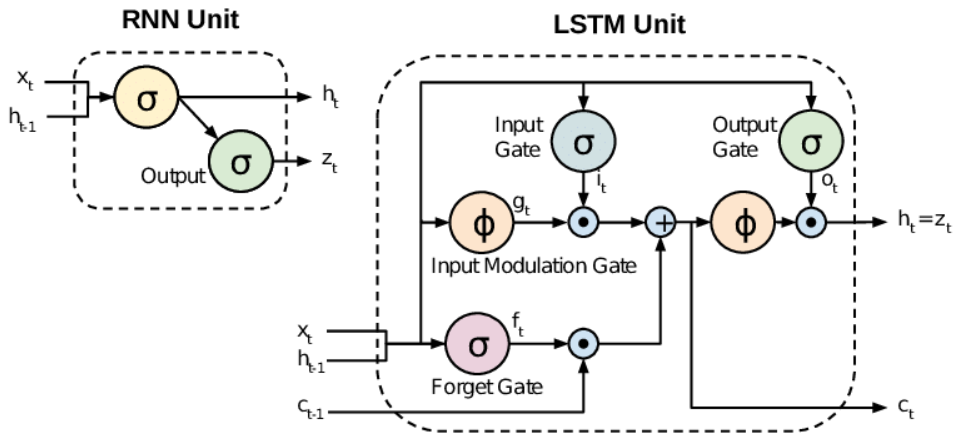

In [2]:
Image('rnn-lstm.png')

In [1]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt


In [2]:
bit_data=pd.read_csv("/content/drive/MyDrive/data/bitstampUSD_1-min_data_2012-01-01_to_2019-03-13.csv")
bit_data["date"]=pd.to_datetime(bit_data["Timestamp"],unit="s").dt.date
group=bit_data.groupby("date")
data=group["Close"].mean()

In [3]:
data.shape

(2627,)

In [4]:
data.isnull().sum()

0

In [5]:
data.head()

date
2011-12-31    4.482500
2012-01-01    4.806667
2012-01-02    5.000000
2012-01-03    5.252500
2012-01-04    5.223333
Name: Close, dtype: float64

Here I will set our values between 0-1 in order to avoid domination of high values.

In [6]:
close_train=data.iloc[:len(data)-50]
close_test=data.iloc[len(close_train):]

In [7]:
#feature scalling (set values between 0-1)
close_train=np.array(close_train)
close_train=close_train.reshape(close_train.shape[0],1)
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
close_scaled=scaler.fit_transform(close_train)

Let's choose each 50 data as x-train and 51th as y-train

In [8]:
timestep=50
x_train=[]
y_train=[]

for i in range(timestep,close_scaled.shape[0]):
    x_train.append(close_scaled[i-timestep:i,0])
    y_train.append(close_scaled[i,0])

x_train,y_train=np.array(x_train),np.array(y_train)
x_train=x_train.reshape(x_train.shape[0],x_train.shape[1],1) #reshaped for RNN
print("x_train shape= ",x_train.shape)
print("y_train shape= ",y_train.shape)

x_train shape=  (2527, 50, 1)
y_train shape=  (2527,)


In [9]:
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, Dropout,Flatten

regressor=Sequential()
#first RNN layer
regressor.add(SimpleRNN(128,activation="relu",return_sequences=True,input_shape=(x_train.shape[1],1)))
regressor.add(Dropout(0.25))
#second RNN layer
regressor.add(SimpleRNN(256,activation="relu",return_sequences=True))
regressor.add(Dropout(0.25))
#third RNN layer
regressor.add(SimpleRNN(512,activation="relu",return_sequences=True))
regressor.add(Dropout(0.35))
#fourth RNN layer
regressor.add(SimpleRNN(256,activation="relu",return_sequences=True))
regressor.add(Dropout(0.25))
#fifth RNN layer
regressor.add(SimpleRNN(128,activation="relu",return_sequences=True))
regressor.add(Dropout(0.25))
#convert the matrix to 1-line
regressor.add(Flatten())
#output layer
regressor.add(Dense(1))

regressor.compile(optimizer="adam",loss="mean_squared_error")
regressor.fit(x_train,y_train,epochs=100,batch_size=64)

Epoch 1/100
40/40 [==============================] - 28s 602ms/step - loss: 0.0086
Epoch 2/100
40/40 [==============================] - 24s 600ms/step - loss: 0.0022
Epoch 3/100
40/40 [==============================] - 24s 598ms/step - loss: 0.0013
Epoch 4/100
40/40 [==============================] - 24s 603ms/step - loss: 0.0021
Epoch 5/100
40/40 [==============================] - 24s 605ms/step - loss: 0.0015
Epoch 6/100
40/40 [==============================] - 24s 605ms/step - loss: 0.0012
Epoch 7/100
40/40 [==============================] - 24s 601ms/step - loss: 9.5507e-04
Epoch 8/100
40/40 [==============================] - 24s 599ms/step - loss: 8.4346e-04
Epoch 9/100
40/40 [==============================] - 24s 602ms/step - loss: 8.8004e-04
Epoch 10/100
40/40 [==============================] - 24s 603ms/step - loss: 7.2327e-04
Epoch 11/100
40/40 [==============================] - 24s 601ms/step - loss: 7.7811e-04
Epoch 12/100
40/40 [==============================] - 24s 606ms/s

In [10]:
inputs=data[len(data)-len(close_test)-timestep:]
inputs=inputs.values.reshape(-1,1)
inputs=scaler.transform(inputs)

In [11]:
x_test=[]
for i in range(timestep,inputs.shape[0]):
    x_test.append(inputs[i-timestep:i,0])
x_test=np.array(x_test)
x_test=x_test.reshape(x_test.shape[0],x_test.shape[1],1)

In [12]:
predicted_data=regressor.predict(x_test)
predicted_data=scaler.inverse_transform(predicted_data)

In [13]:
data_test=np.array(close_test)
data_test=data_test.reshape(len(data_test),1)

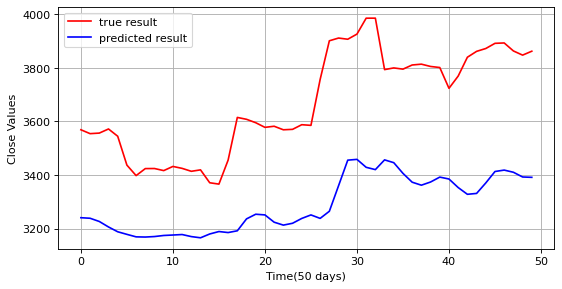

In [14]:
plt.figure(figsize=(8,4), dpi=80, facecolor='w', edgecolor='k')
plt.plot(data_test,color="r",label="true result")
plt.plot(predicted_data,color="b",label="predicted result")
plt.legend()
plt.xlabel("Time(50 days)")
plt.ylabel("Close Values")
plt.grid(True)
plt.show()

In [15]:
from sklearn.metrics import mean_absolute_error
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout,Flatten

model=Sequential()

model.add(LSTM(10,input_shape=(None,1),activation="relu"))

model.add(Dense(1))

model.compile(loss="mean_squared_error",optimizer="adam")

model.fit(x_train,y_train,epochs=100,batch_size=32)

Epoch 1/100
79/79 [==============================] - 3s 20ms/step - loss: 0.0055
Epoch 2/100
79/79 [==============================] - 2s 20ms/step - loss: 4.2507e-04
Epoch 3/100
79/79 [==============================] - 2s 20ms/step - loss: 3.1097e-04
Epoch 4/100
79/79 [==============================] - 2s 20ms/step - loss: 3.1113e-04
Epoch 5/100
79/79 [==============================] - 2s 20ms/step - loss: 2.9401e-04
Epoch 6/100
79/79 [==============================] - 2s 20ms/step - loss: 2.7351e-04
Epoch 7/100
79/79 [==============================] - 2s 20ms/step - loss: 2.6485e-04
Epoch 8/100
79/79 [==============================] - 2s 20ms/step - loss: 2.6107e-04
Epoch 9/100
79/79 [==============================] - 2s 20ms/step - loss: 2.3732e-04
Epoch 10/100
79/79 [==============================] - 2s 20ms/step - loss: 2.5327e-04
Epoch 11/100
79/79 [==============================] - 2s 20ms/step - loss: 2.1485e-04
Epoch 12/100
79/79 [==============================] - 2s 20ms/step 

In [16]:
inputs=data[len(data)-len(close_test)-timestep:]
inputs=inputs.values.reshape(-1,1)
inputs=scaler.transform(inputs)

In [17]:
x_test=[]
for i in range(timestep,inputs.shape[0]):
    x_test.append(inputs[i-timestep:i,0])
x_test=np.array(x_test)
x_test=x_test.reshape(x_test.shape[0],x_test.shape[1],1)

In [18]:
predicted_data=model.predict(x_test)
predicted_data=scaler.inverse_transform(predicted_data)

In [19]:
data_test=np.array(close_test)
data_test=data_test.reshape(len(data_test),1)

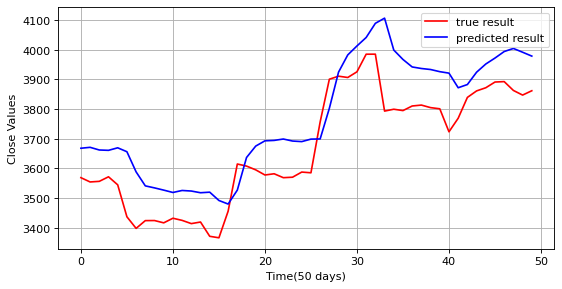

In [20]:
plt.figure(figsize=(8,4), dpi=80, facecolor='w', edgecolor='k')
plt.plot(data_test,color="r",label="true result")
plt.plot(predicted_data,color="b",label="predicted result")
plt.legend()
plt.xlabel("Time(50 days)")
plt.ylabel("Close Values")
plt.grid(True)
plt.show()